In [1]:
import torch
from state_quantization.transforms import NormalizeTransform
from envs.IBGym_mod_envs import IBGymModded, IBGymQ
import numpy as np
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
from q_learning.algorithm import QLearning
from envs.env_creator import env_creator
from q_learning.algorithm import QLPolicy

## Init Model and env

In [2]:
device = 'cpu'
policy_path = 'q_learning/q_policy.pkl'
steps_per_episode = 1000
env_kwargs = {'steps_per_episode': steps_per_episode,'device':device}

In [3]:
alpha = 0.1
gamma = 0.995
#epsilon = 0.05
total_epochs = 1750
epsilon = np.linspace(0.5, 0.06, 1200)
q_table = {}
# For plotting metrics
all_epochs = []
all_penalties = []
mean_reward_per_epoch = []
state_space_size = []

## Train policy

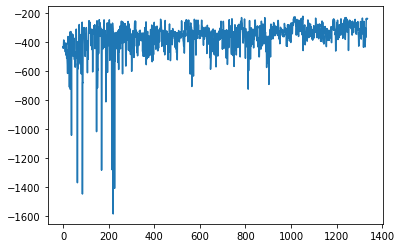

Episode 1335 Reward: -237.46717133570965
Total States: 141


KeyboardInterrupt: 

In [4]:


algo = QLearning()

algo.train(epochs=total_epochs,alpha=alpha,gamma=gamma,epsilon=epsilon,env_creator=env_creator, env_kwargs=env_kwargs,reward_offset=2000)

## Save Policy

In [5]:
algo.policy.save(policy_path)
del algo

## Load Policy

In [4]:


policy = QLPolicy.load(policy_path)
algo = QLearning(policy=policy)

## Evaluate policy

Episode 2 Reward: -236.00846517012678


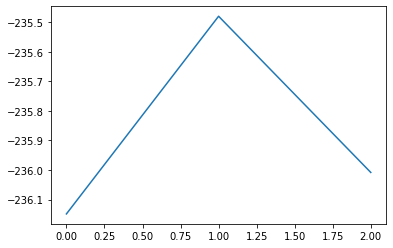

KeyboardInterrupt: 

In [5]:
algo.evaluate(epochs=100,env_creator=env_creator,env_kwargs=env_kwargs)